# Sinkhorn divergence gradient flows

Let $\mathrm{OT_\varepsilon}(\alpha, \beta)$ the entropic regularized OT distance between two distributions $\alpha$ and $\beta$. One issue with $\mathrm{OT_\varepsilon}$ is that $\mathrm{OT_\varepsilon}(\alpha, \alpha)$ is not equal to 0.

The Sinkhorn divergence, defined in {cite}`genevay:18` as $\mathrm{S}_\varepsilon(\alpha, \beta) = \mathrm{OT_\varepsilon}(\alpha, \beta) - \frac{1}{2}\mathrm{OT_\varepsilon}(\alpha, \alpha) - \frac{1}{2}\mathrm{OT_\varepsilon}(\beta, \beta)$ removes this entropic bias.

In this tutorial we showcase the advantage of removing the entropic bias using gradient flows on 2-D distributions, as done in {cite}`feydy:19` and following the {doc}`../geometry/000_point_cloud` tutorial.

## Imports

In [ ]:
import functools
from typing import Any, Callable

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers import linear
from ott.tools import plot, sinkhorn_divergence

## Sampling Source/Target Distributions

Let us start by defining simple source and target distributions.

In [2]:
key1, key2 = jax.random.split(jax.random.key(0), 2)

x = 0.25 * jax.random.normal(key1, (25, 2))  # Source
y = 0.5 * jax.random.normal(key2, (50, 2)) + jnp.array((6, 0))  # Target

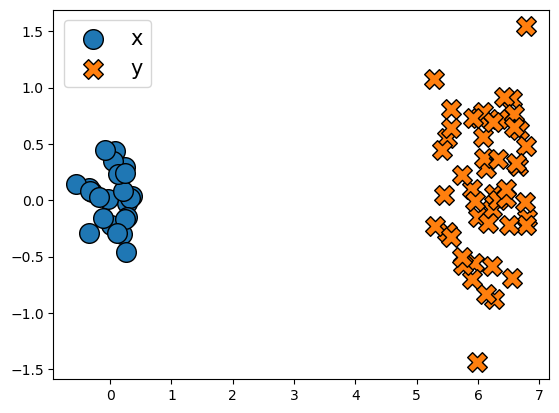

In [3]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

## Gradient Flow of a Divergence

The code below performs gradient descent to move points in a point cloud ``x`` in a way that minimizes a divergence to another point cloud ``y``, ``divergence(x, y, epsilon)``.

In [4]:
def gradient_flow(
    x: jnp.ndarray,
    y: jnp.ndarray,
    divergence: Callable[[jnp.ndarray, jnp.ndarray, float], tuple[float, Any]],
    div_name: str = "Obj",
    num_iter: int = 500,
    lr: float = 0.2,
    dump_every: int = 50,
    epsilon: float = None,
):
    """Compute an entropic Wasserstein (possibly debiased) gradient flow."""

    ots = []

    # Apply jax.value_and_grad operator and jit that function.
    divergence_vg = jax.jit(jax.value_and_grad(divergence, has_aux=True))

    # Perform gradient descent on `x`.
    titles = []
    for i in range(0, num_iter + 1):
        (cost, ot), grad_x = divergence_vg(x, y, epsilon=epsilon)
        assert ot.converged
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.
            titles.append(rf"Iter = {i:d}, " + div_name + rf": {cost:.5f}")
        x = x - grad_x * lr  # Perform a gradient descent step.

    return ots, titles

In [5]:
def display_animation(ots, titles, plot_class=plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, titles=titles, frame_rate=1)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

## Gradient Flow of $\mathrm{OT}_\varepsilon$

We set the ``divergence`` to be the regularized OT cost.

In [6]:
def reg_ot_cost(x, y, epsilon=None):
    """Return the OT cost and OT output given a geometry."""
    geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
    ot = linear.solve(geom)
    return ot.reg_ot_cost, ot

For the default value of $\varepsilon$, the gradient flow behaves as expected:

In [7]:
# Compute and display the gradient flow for the regularized OT cost.
ots, titles = gradient_flow(
    x, y, divergence=reg_ot_cost, div_name="Reg OT Cost"
)
display_animation(ots, titles)

But for a larger $\varepsilon$, the distribution collapses:

In [8]:
# Compute and display the gradient flow for a larger value of epsilon.
ots, titles = gradient_flow(
    x, y, reg_ot_cost, epsilon=1.0, div_name="Reg OT Cost"
)
display_animation(ots, titles)

This is expected: the regularized OT plan collapses to a rank $1$ matrix (here the matrix of ones divided by $nm$) and simply leads all points in $x$ to the mean of points in $y$.

Let us fix this by choosing for the divergence the debiased Sinkhorn divergence, $\mathrm{S}_\varepsilon$.

## Gradient flow with $\mathrm{S}_\varepsilon$

By slightly adapting the previous function, we can compute the gradient flow of the :term:`Sinkhorn divergence` using the {func}`~ott.tools.sinkhorn_divergence.sinkdiv` method designed to compare two point clouds, instead of the regularized OT cost.

We also have to adapt the plotting object slightly to deal with the fact that we have Sinkhorn divergence outputs, which have multiple geometries.

In [9]:
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y

Thanks to the debiasing, the distributions overlap nicely, even for a large $\varepsilon$.

In [10]:
epsilon = 1.0

# Storing and passing the reg_ot_cost for the second point cloud once and for
# all avoids having to recompute it at each iteration.
geom = pointcloud.PointCloud(y, y, epsilon=epsilon)
ot_cost_yy = linear.solve(geom).reg_ot_cost

# We specify that we do not wish to recompute the third term in the Sinkhorn
# divergence.
sd = jax.jit(
    functools.partial(
        sinkhorn_divergence.sinkdiv, static_b=True, offset_static_b=ot_cost_yy
    )
)


def sink_div(x, y, epsilon=None):
    return sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud,
        x=x,
        y=y,
        epsilon=epsilon,
        static_b=True,
    )


ots, titles = gradient_flow(x, y, sd, epsilon=epsilon, div_name="Sink Div")
display_animation(ots, titles, plot_class=CustomPlot)